In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Input,Flatten,Dense,Conv2D,MaxPooling2D,Dropout,concatenate,Conv2DTranspose
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import zipfile
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/archive/dataset'

In [ ]:
main_dir = os.listdir(folder_path)
main_dir

['test', 'valid', 'train']

In [ ]:
train_dir = r"/content/drive/My Drive/archive/dataset/train"
valid_dir = r"/content/drive/My Drive/archive/dataset/valid"
os.listdir(train_dir),os.listdir(valid_dir)

(['yes', 'no'], ['yes', 'no'])

In [ ]:

def data_generation(path):
    """
    Generate data (images and corresponding labels) from the given directory path.

    Args:
    - path (str): Path to the directory containing subdirectories with image files.

    Returns:
    - images (list): List of images, where each image is a numpy array.
    - labels (list): List of labels corresponding to the images.

    Each image is resized to (256, 256) and converted to grayscale.
    The labels are extracted from the subdirectory names.
    """
    images = []
    labels = []
    for i in os.listdir(path):
        p = os.path.join(path, i)
        for j in os.listdir(p):
            img_path = os.path.join(p, j)
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (256, 256))
            img_resized = np.expand_dims(img_resized, axis=-1)
            images.append(img_resized)
            labels.append(i)
    return images, labels


In [ ]:
# Generate training data
train_images, train_labels = data_generation(train_dir)

# Generate validation data
valid_images, valid_labels = data_generation(valid_dir)


In [ ]:
# Convert train_images and valid_images to NumPy arrays
train_images = np.array(train_images)
valid_images = np.array(valid_images)

In [ ]:
# Convert train_images and valid_images to float32 and scale the pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.
valid_images = valid_images.astype('float32') / 255.

In [ ]:
# Assuming x_test is your testing data and y_test is the corresponding labels
train_images_shape = train_images.shape
train_labels_shape = np.array(train_labels).shape

print("Shape of x_test:", train_images_shape)
print("Shape of y_test:", train_labels_shape)


Shape of x_test: (2800, 256, 256, 1)
Shape of y_test: (2800,)


In [ ]:
# Assuming x_test is your testing data and y_test is the corresponding labels
valid_images_shape = valid_images.shape
valid_labels_shape = np.array(valid_labels).shape

print("Shape of x_test:", valid_images_shape)
print("Shape of y_test:", valid_labels_shape)


Shape of x_test: (200, 256, 256, 1)
Shape of y_test: (200,)


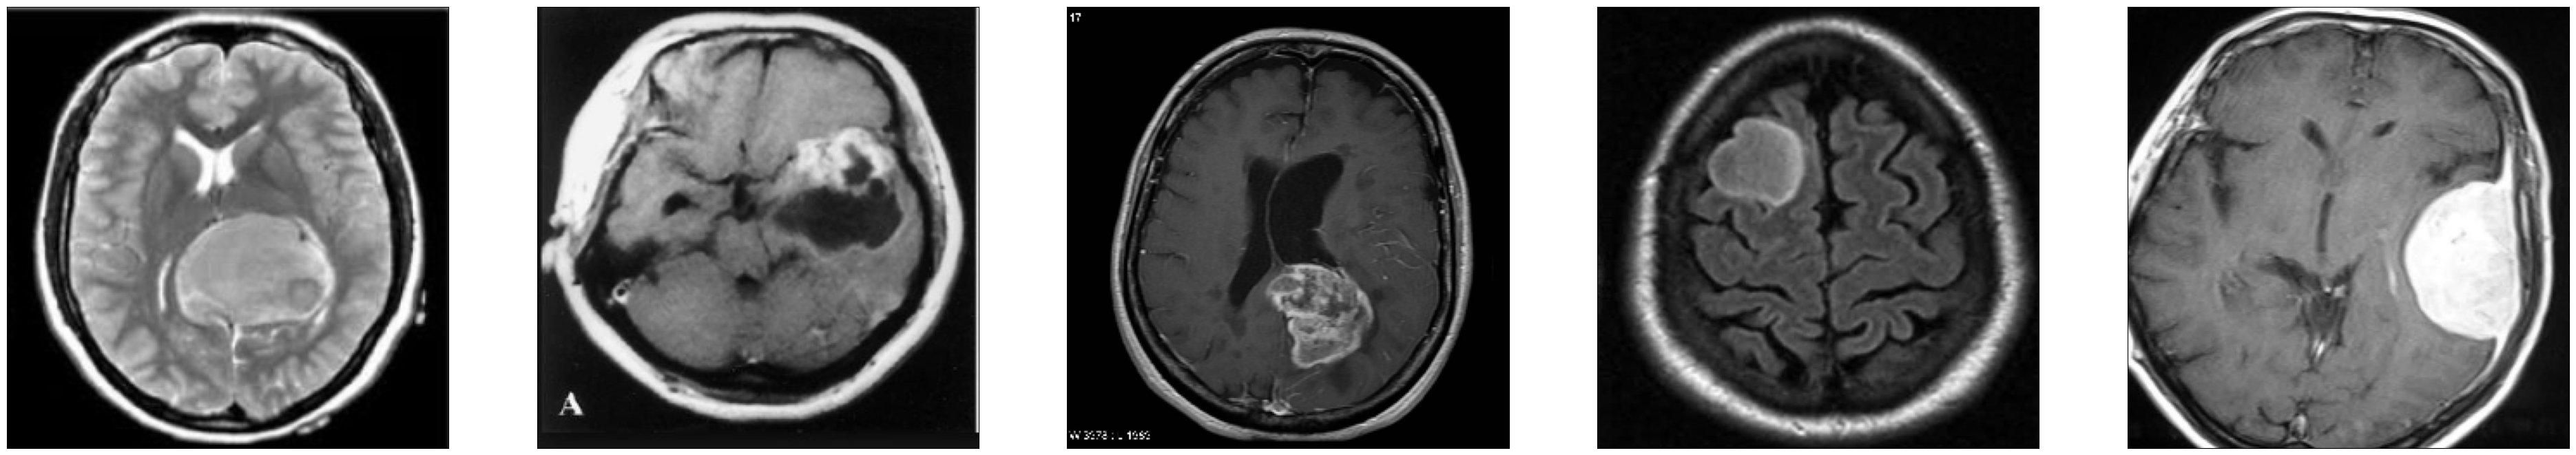

In [ ]:
import matplotlib.pyplot as plt

def display_images(images, n=10):
    """
    Display a grid of images.

    Args:
    - images (list or numpy array): List or array of images to display.
    - n (int): Number of images to display. Default is 10.

    The function displays a grid of the first n images from the provided list or array.
    """
    plt.figure(figsize=(48, 48))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap='gray')  # Display images in grayscale
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Display the first 10 images from train_images
display_images(train_images, n=5)

In [ ]:
import numpy as np

def add_noise(data, noise_factor=0.1):
    """
    Add random noise to the input data.

    Args:
    - data (numpy array): Input data to which noise will be added.
    - noise_factor (float): Factor controlling the amount of noise to be added.
                            Default is 0.1.

    Returns:
    - noisy_data (numpy array): Data with random noise added.

    This function adds random noise to the input data based on the specified noise_factor.
    It uses numpy's random.normal function to generate random noise with mean 0 and standard deviation 1.
    The noisy data is then obtained by adding the scaled noise to the input data and clipping it to [0, 1].
    """
    # Generate random noise
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)

    # Add noise to the input data
    noisy_data = data + noise

    # Clip the noisy data to ensure it remains in the range [0, 1]
    noisy_data = np.clip(noisy_data, 0., 1.)

    return noisy_data

# Add noise to the training and testing data
train_images_noisy = add_noise(train_images, noise_factor=0.1)
valid_images_noisy = add_noise(valid_images, noise_factor=0.1)


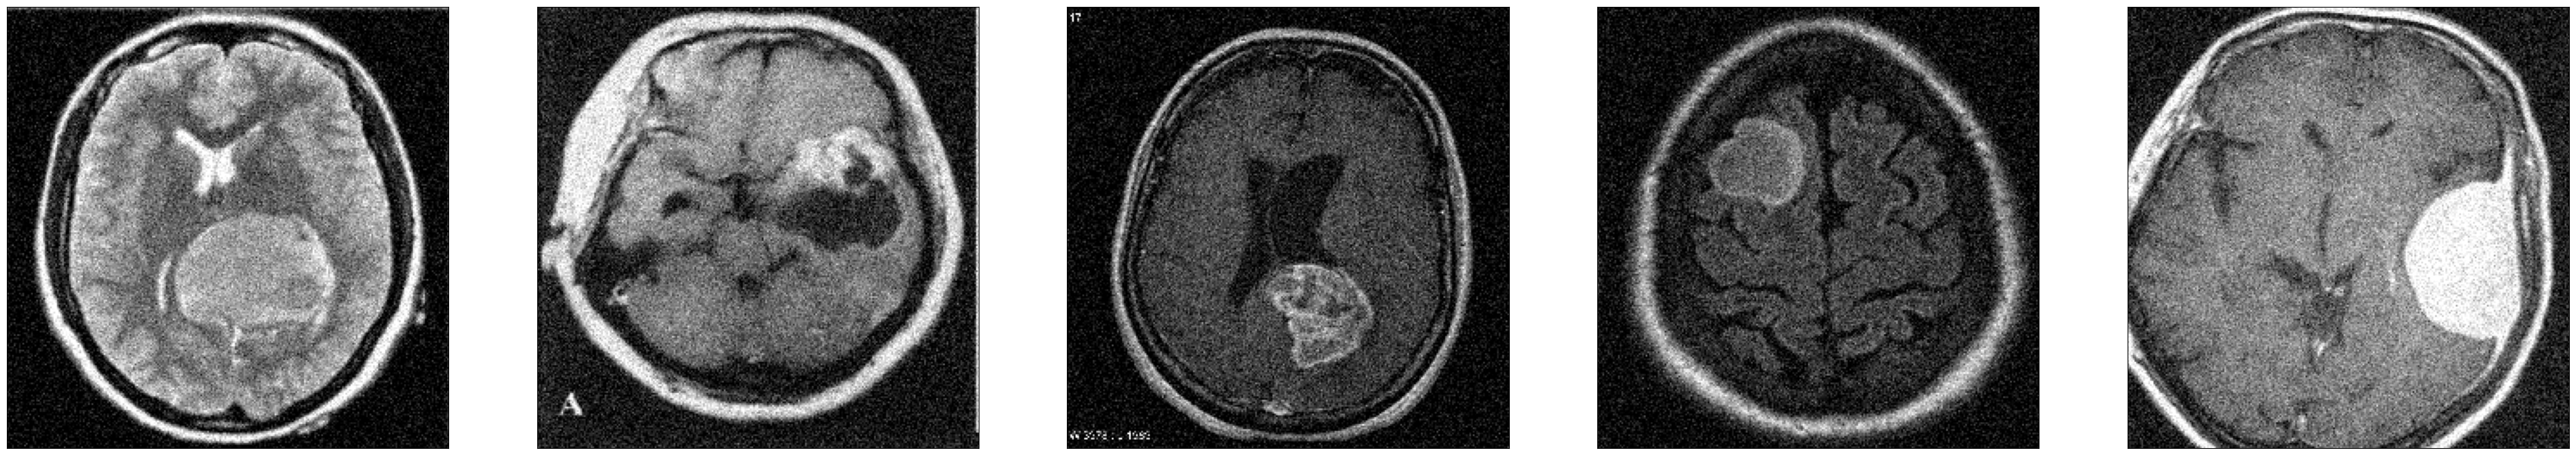

In [ ]:

def display_noisy_images(images, n=5):
    """
    Display a grid of noisy images.

    Args:
    - images (list or numpy array): List or array of noisy images to display.
    - n (int): Number of noisy images to display. Default is 10.

    This function displays a grid of the first n noisy images from the provided list or array.
    """
    plt.figure(figsize=(48, 48))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap='gray')  # Display images in grayscale
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Display the first 10 noisy images from train_images_noisy
display_noisy_images(train_images_noisy, n=5)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate

def unet_dilated( num_classes=1):
    """
    Implementation of the U-Net architecture with dilated convolutions.

    Args:
    - input_shape (tuple): Shape of input images. Default is (256, 256, 1).
    - num_classes (int): Number of output classes. Default is 1.

    Returns:
    - model (keras Model): U-Net model with dilated convolutions.
    """

    input_layer = Input(shape=(256, 256, 1), dtype='float32', name='input_layer')


    # Contracting path (encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Dilated convolution with dilation rate of 2
    conv3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=2)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Dilated convolution with dilation rate of 2
    conv4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=2)(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Dilated convolution with dilation rate of 2
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=2)(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=2)(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive path (decoder)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate(axis=3)([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(num_classes, 1, activation='sigmoid', padding='same')(conv9)

    # Create model
    model = Model(inputs=input_layer, outputs=conv9)

    return model

# Create U-Net model with dilated convolutions
model_dilated = unet_dilated()

In [ ]:
from keras.optimizers import Adam

# Compile the model with appropriate optimizer and loss function
model_dilated.compile(optimizer=Adam(), loss='mean_squared_error')

In [ ]:
model_dilated.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
pip install pydot

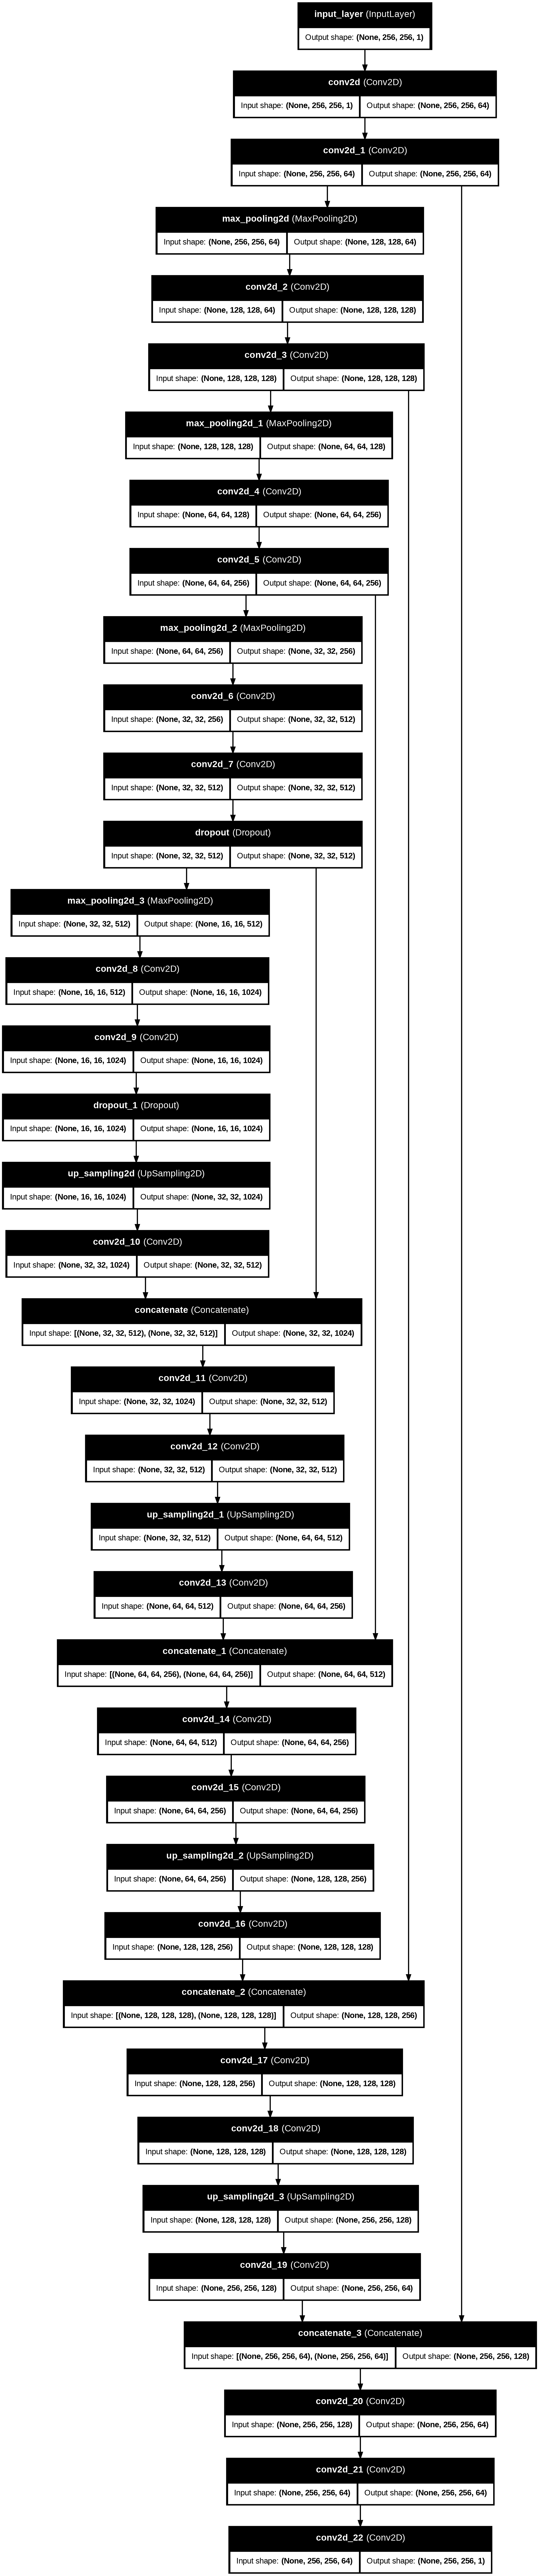

In [ ]:
from keras.utils import plot_model
import pydot

# Visualize the U-Net model with pydot
plot_model(model_dilated, to_file='unet_dilated.png', show_shapes=True, show_layer_names=True, rankdir='TB')


In [ ]:
# Fit the model with noisy images as input and clean images as output
history = model_dilated.fit(train_images_noisy,train_images, epochs=3, batch_size=32, validation_data=(valid_images_noisy,valid_images))

Epoch 1/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - loss: 0.1523 - val_loss: 0.1388
Epoch 2/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 0.1582 - val_loss: 0.1388
Epoch 3/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.1546 - val_loss: 0.1388


In [ ]:
#saving model
model_dilated.save('denoising.h5')

In [ ]:
from tensorflow.keras.models import load_model
model_dialted = load_model('denoising.h5')

In [ ]:
def predict_denoised_images(model, noisy_images):
    """
    Predict denoised images using the provided U-Net model.

    Args:
    - model (keras Model): The trained U-Net model for denoising images.
    - noisy_images (numpy array): Array containing noisy images to be denoised.

    Returns:
    - denoised_images (numpy array): Array containing denoised images.
    """
    # Predict denoised images
    denoised_images = model.predict(noisy_images)

    return denoised_images


In [ ]:
# Predict denoised images for training set
train_denoised_images = predict_denoised_images(model_dilated, train_images_noisy)

# Predict denoised images for validation set
valid_denoised_images = predict_denoised_images(model_dilated, valid_images_noisy)

88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 882ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 613ms/step


In [ ]:
output_folder = 'trained_denoised_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save denoised images
for i, image in enumerate(train_denoised_images):
    # Ensure image has the correct shape
    if len(image.shape) == 2:
        # If grayscale, add a third dimension
        image = np.expand_dims(image, axis=-1)
    elif len(image.shape) != 3:
        raise ValueError(f"Unexpected image shape: {image.shape}")

    # Convert image datatype to uint8
    image = (image * 255).astype(np.uint8)

    # Check if the image is grayscale and convert to RGB if necessary
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)

    # Save image
    filename = f'denoised_{i}.png'  # Adjust filename as needed
    filepath = os.path.join(output_folder, filename)
    plt.imsave(filepath, image)


In [ ]:
def display_images(images, figsize=(40, 48),n=5):
    """
    Display a grid of images.

    Parameters:
    - images (list or array-like): List of images to display.
    - figsize (tuple, optional): Figure size in inches. Defaults to (40, 48).

    Returns:
    None
    """
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.gray()  # Set colormap to grayscale
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

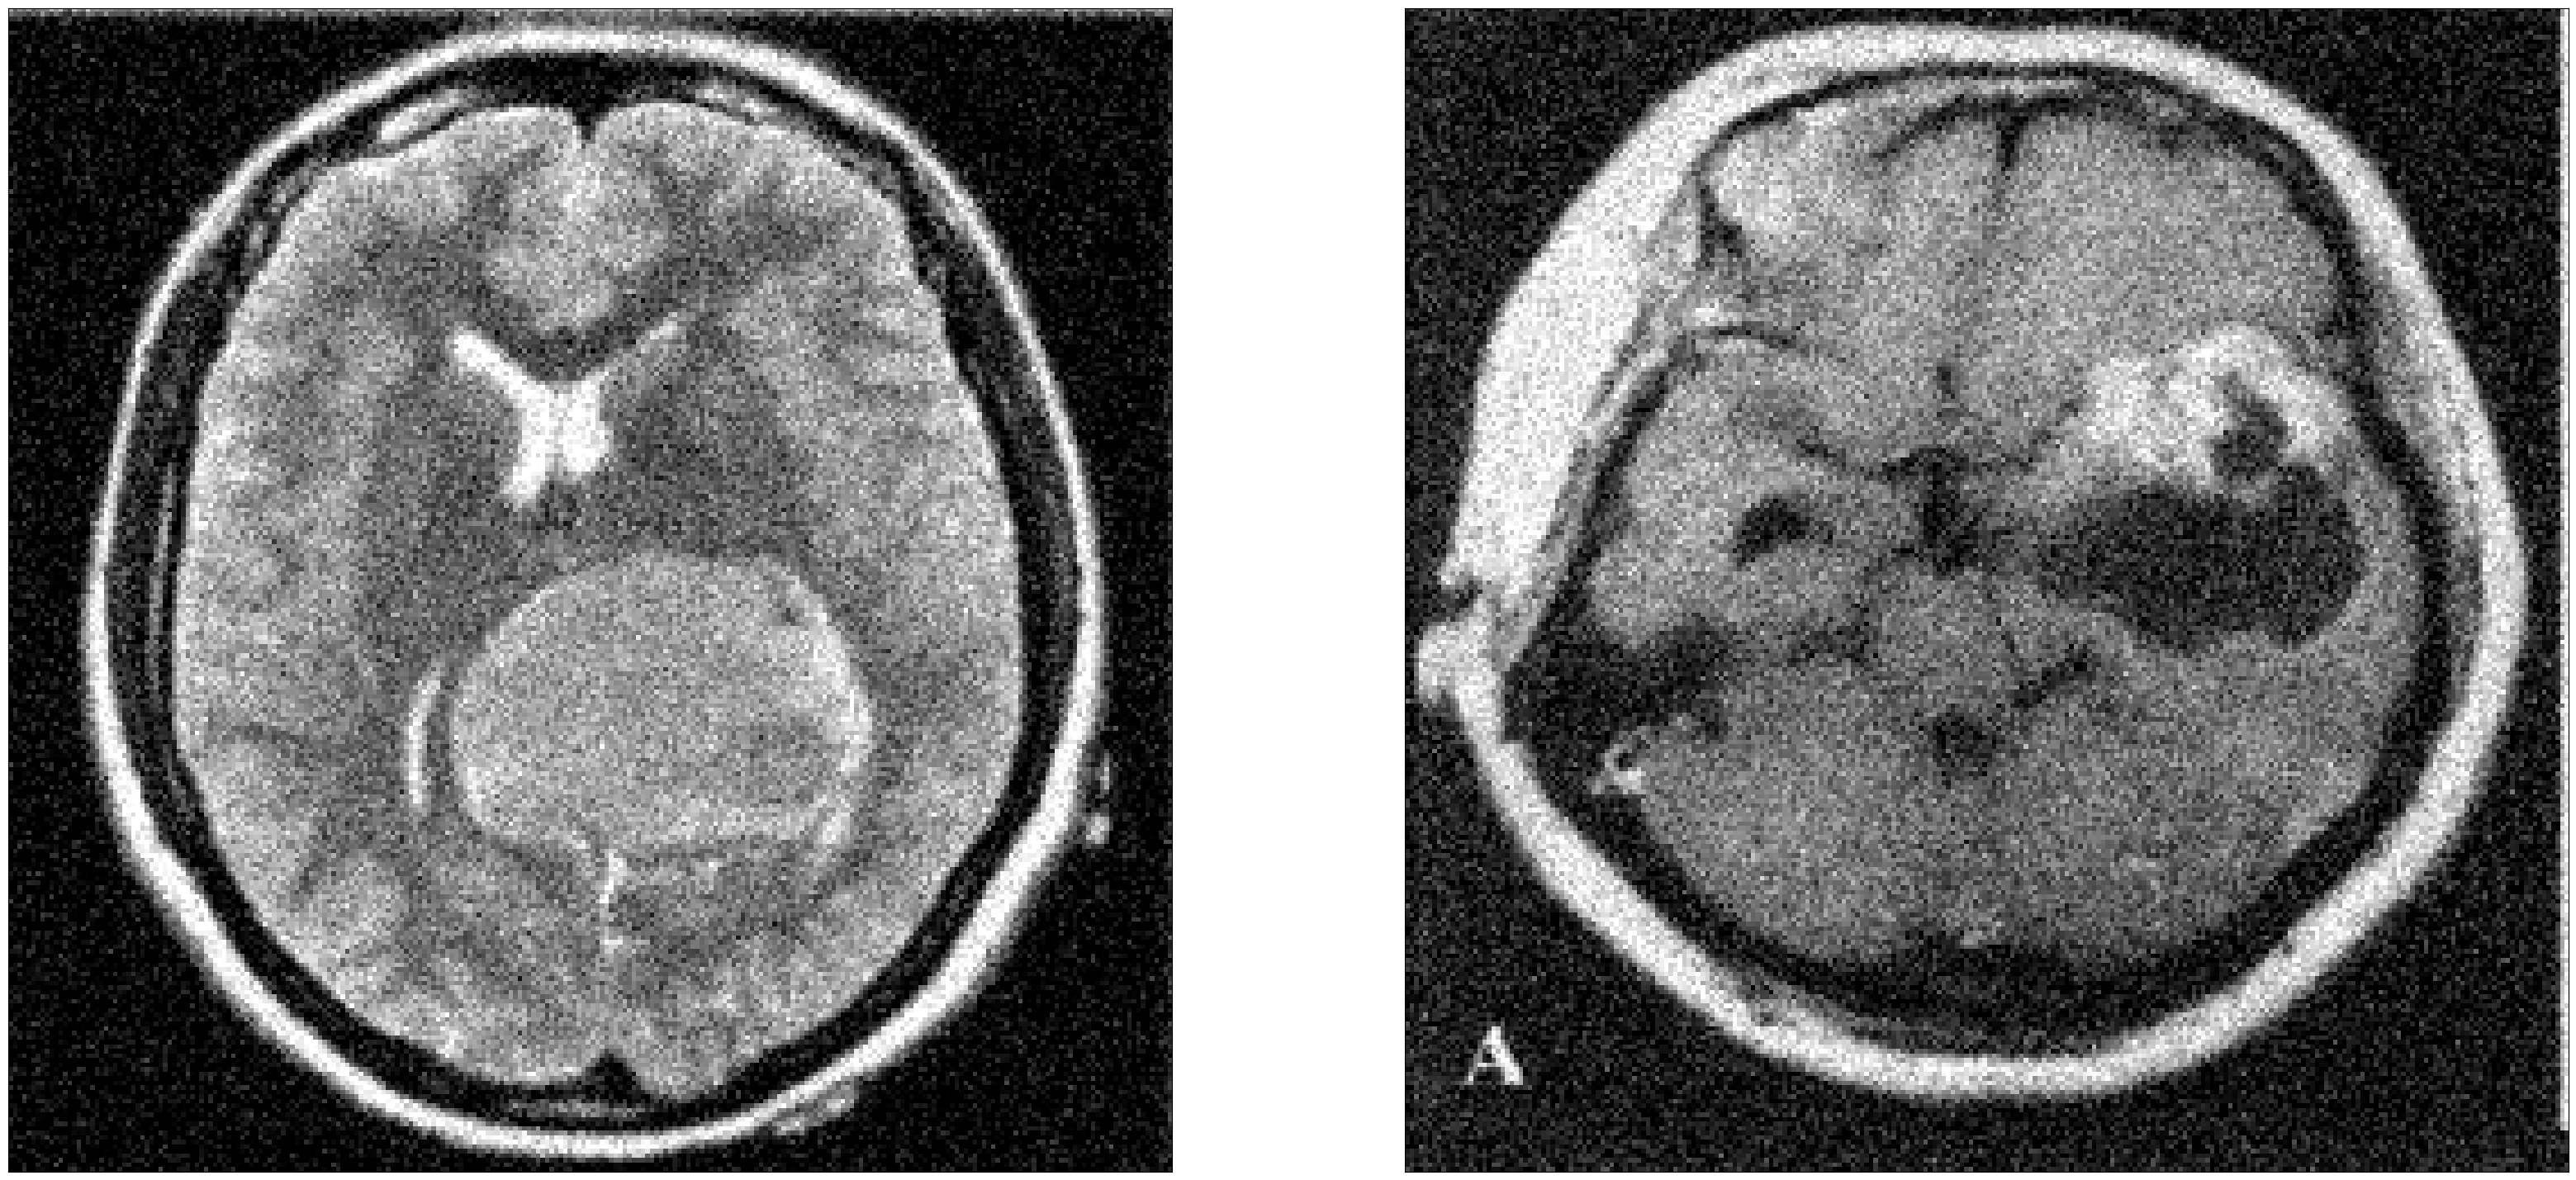

In [ ]:
# Before Denoising
display_images(train_images_noisy,n=2)

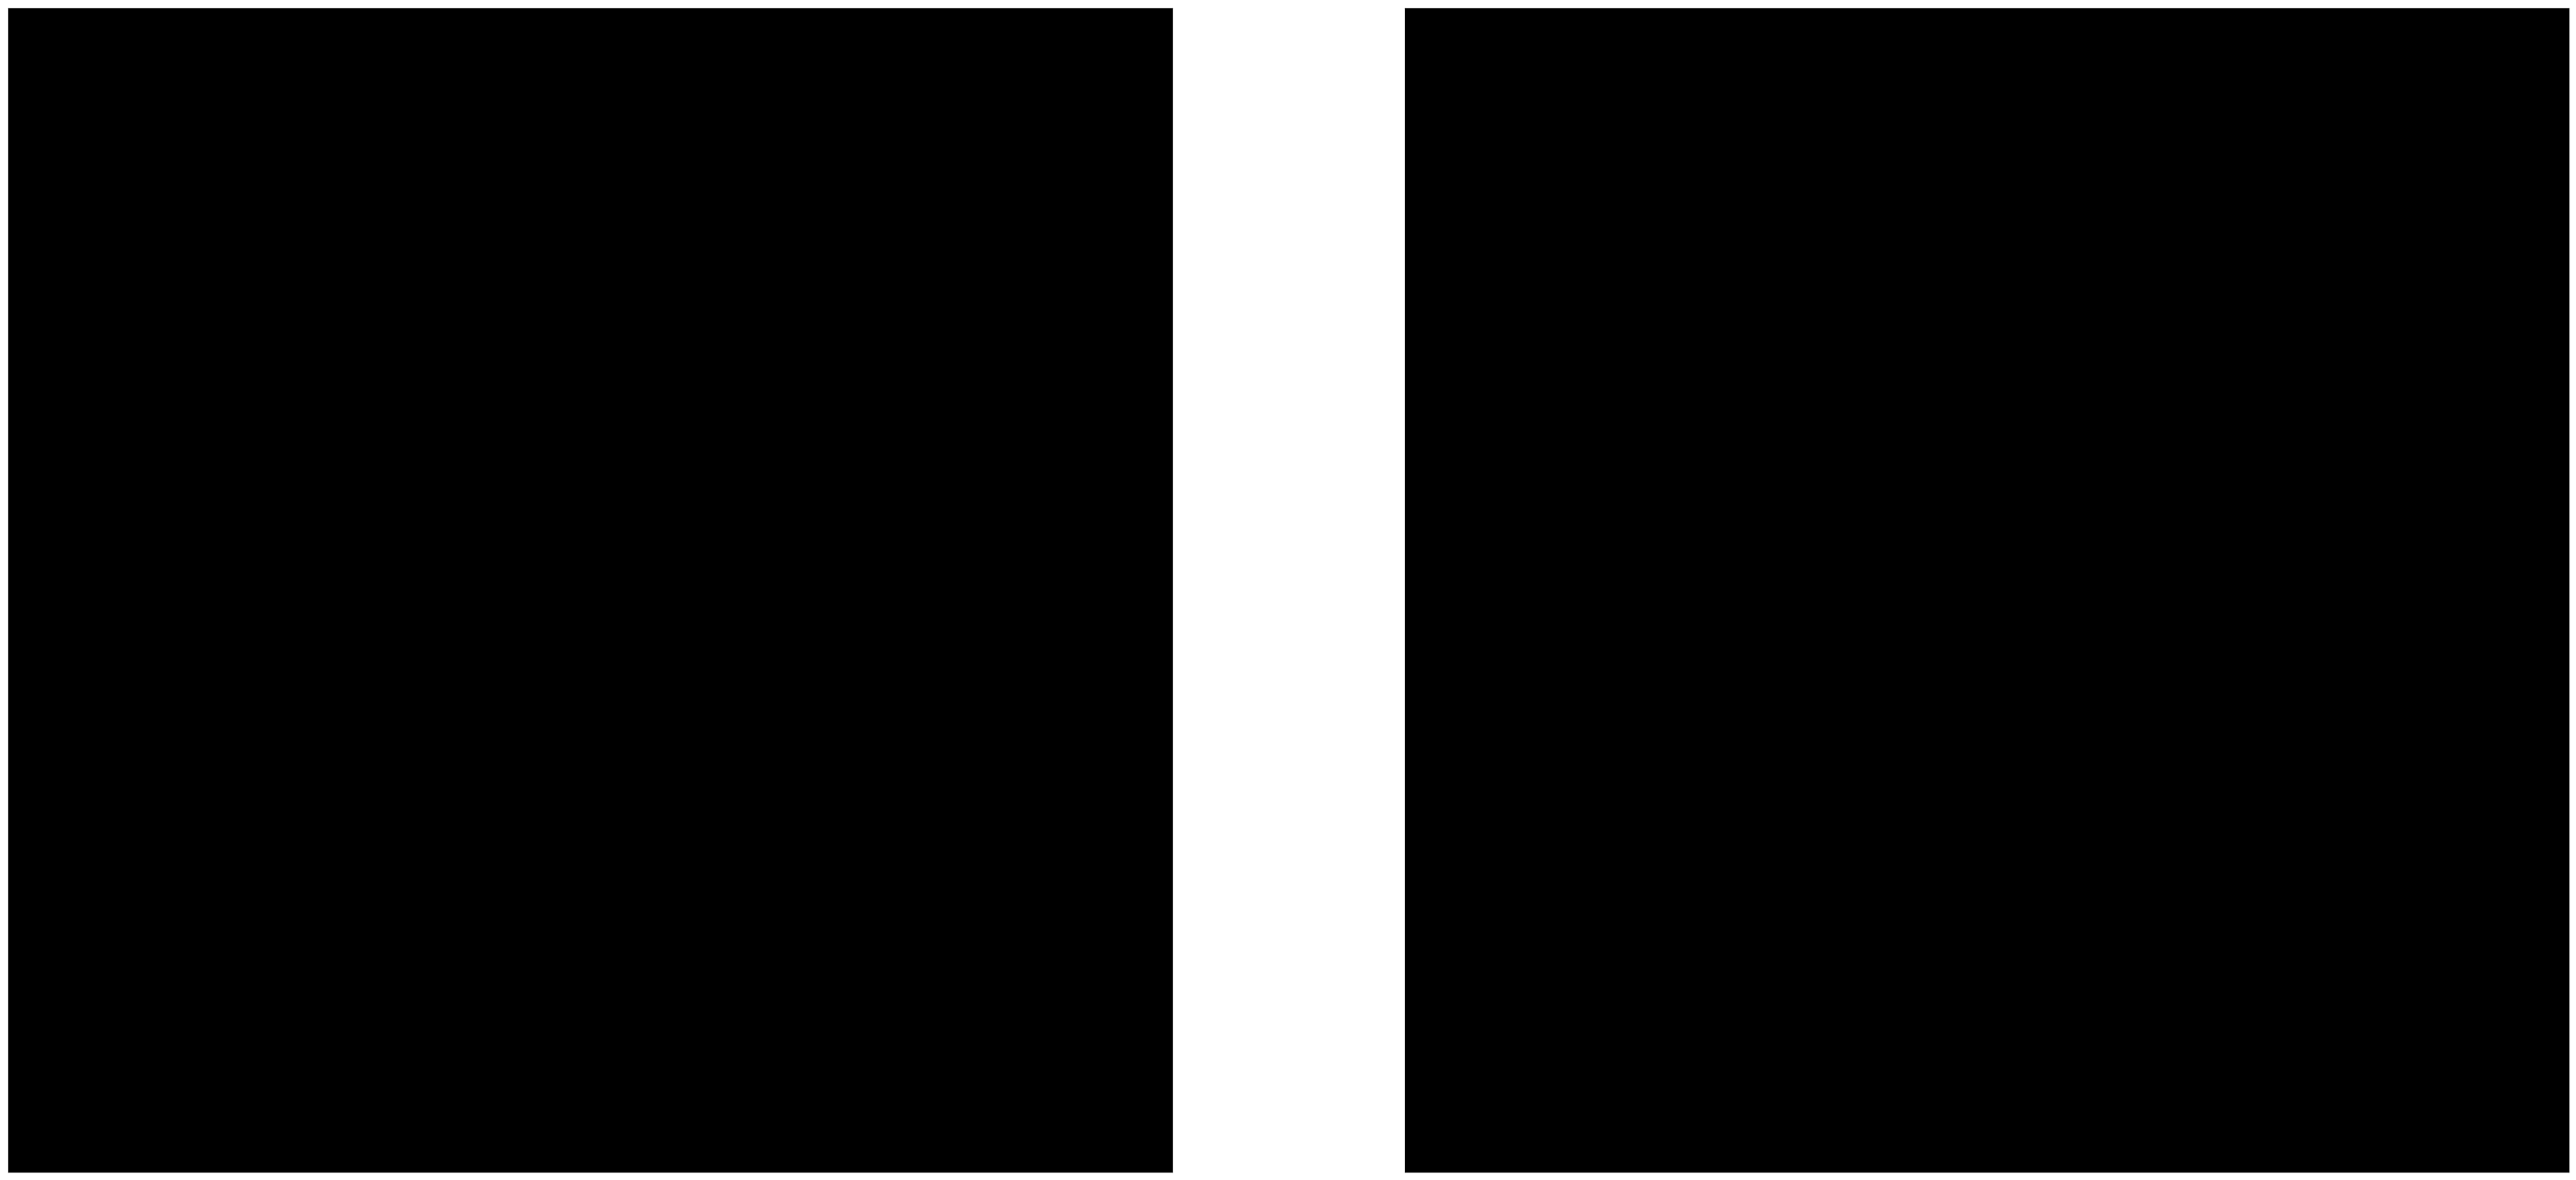

In [ ]:
#denoised_images
display_images(train_denoised_images,n=2)

<Figure size 640x480 with 0 Axes>

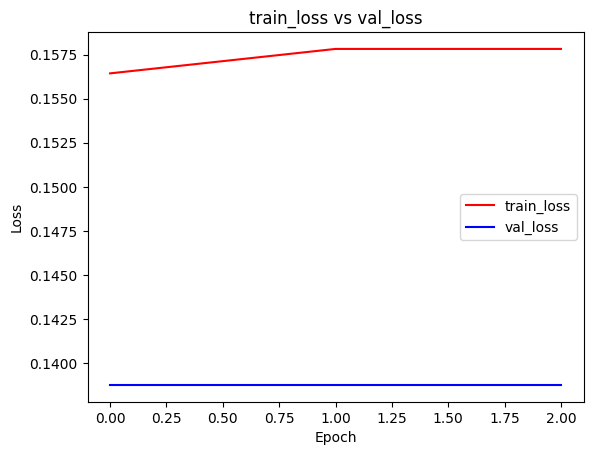

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(history.history['loss']))

plt.plot(epochs,history.history['loss'],'r', label='train_loss')
plt.plot(epochs,history.history['val_loss'],'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

In [ ]:
def calculate_psnr(img1, img2):
    import math
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    PSNR is a measure of image quality, defined as 20 * log10(MAX_I / sqrt(MSE)),
    where MAX_I is the maximum possible pixel value (usually 255 for 8-bit images),
    and MSE is the Mean Squared Error between the two images.

    Parameters:
    - img1 (numpy.ndarray): First image.
    - img2 (numpy.ndarray): Second image.

    Returns:
    - psnr (float): The PSNR value between the two images. If the images are identical,
      returns infinity.
    """
    # Convert images to float64 for precision
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((img1 - img2) ** 2)

    # If MSE is 0, images are identical, return infinity
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    psnr = 20 * math.log10(255.0 / math.sqrt(mse))
    return psnr

In [ ]:
#psnr
psnr = calculate_psnr(train_images,train_denoised_images)

In [ ]:
  """
    Calculate the Structural Similarity Index Measure (SSIM) between two images.

    SSIM is a metric that quantifies the similarity between two images.
    It considers luminance, contrast, and structure of images.

    Parameters:
    - image1 (tf.Tensor or array-like): The first image.
    - image2 (tf.Tensor or array-like): The second image.
    - max_val (float): The maximum possible pixel value (usually 255 for 8-bit images).
    - filter_size (int, optional): The size of the Gaussian filter. Defaults to 11.
    - filter_sigma (float, optional): The standard deviation of the Gaussian filter. Defaults to 1.5.
    - k1 (float, optional): The constant used to stabilize the division with weak denominator. Defaults to 0.01.
    - k2 (float, optional): The constant used to stabilize the division with weak denominator. Defaults to 0.03.
    - return_index_map (bool, optional): Whether to return the SSIM index map. Defaults to False.

    Returns:
    - ssim (tf.Tensor or float): The computed SSIM value or tensor of SSIM values if images are batched.
    - index_map (tf.Tensor, optional): The SSIM index map if `return_index_map` is True.
    """
import tensorflow as tf
ssim = tf.image.ssim(train_images,train_denoised_images,len(train_images),filter_size=11,
    filter_sigma=1.5,
    k1=0.01,
    k2=0.03,
    return_index_map=False)

In [ ]:
#SSIM
ssim = np.mean(ssim)/len(ssim)

In [ ]:
def calculate_mse(img1, img2):
    """
    Calculate the Mean Squared Error (MSE) between two images.

    Parameters:
    - img1 (numpy.ndarray): First image.
    - img2 (numpy.ndarray): Second image.

    Returns:
    - mse (float): The MSE value between the two images.
    """
    return np.mean((img1 - img2) ** 2)

In [ ]:
mse = calculate_mse(train_images,train_denoised_images)

In [ ]:
from prettytable import PrettyTable
# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Metric", "Value"]

# Add rows to the table
table.add_row(["MSE", "{:.4f}".format(mse)])  # MSE
table.add_row(["PSNR", "{:.2f}".format(psnr)])  # PSNR
table.add_row(["SSIM", "{:.4f}".format(ssim)])  #  SSIM
table.add_row(["DSSIM", "{:.4f}".format( 1.0 - ssim)]) #DSSIM(Structural Dissimilarity)
print(table)

+--------+--------+
| Metric | Value  |
+--------+--------+
|  MSE   | 0.1578 |
|  PSNR  | 56.15  |
|  SSIM  | 0.0004 |
| DSSIM  | 0.9996 |
+--------+--------+


**Classification**

In [ ]:
import numpy as np

# Convert the list of images to a NumPy array
imgs_array = np.array(train_denoised_images)
valid_array = np.array(valid_denoised_images)

print("Shape of imgs_array:", imgs_array.shape)
print("Data type of imgs_array:", imgs_array.dtype)
print("Shape of valid_array:", valid_array.shape)
print("Data type of valid_array:", valid_array.dtype)

Shape of imgs_array: (2800, 256, 256, 1)
Data type of imgs_array: float32
Shape of valid_array: (200, 256, 256, 1)
Data type of valid_array: float32


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)
y_valid_encoded = label_encoder.fit_transform(valid_labels)

In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('val_accuracy')>0.97:
            self.model.stop_training=True

In [ ]:
callback = myCallback()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='linear', input_shape=input_shape),
        LeakyReLU(alpha=0.1),
        Conv2D(32, (3, 3), padding='same', activation='linear'),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='linear'),
        LeakyReLU(alpha=0.1),
        Conv2D(64, (3, 3), padding='same', activation='linear'),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='linear'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Change activation based on your task
    ])

    return model

# Define input shape and number of classes
input_shape = (256, 256, 1)  # adjust dimensions based on your input images
num_classes = 2  # adjust based on your classification task

# Create the model
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     134,218,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,0

 Total params: 134,286,690 (512.26 MB)

 Trainable params: 134,285,474 (512.26 MB)

 Non-trainable params: 1,216 (4.75 KB)

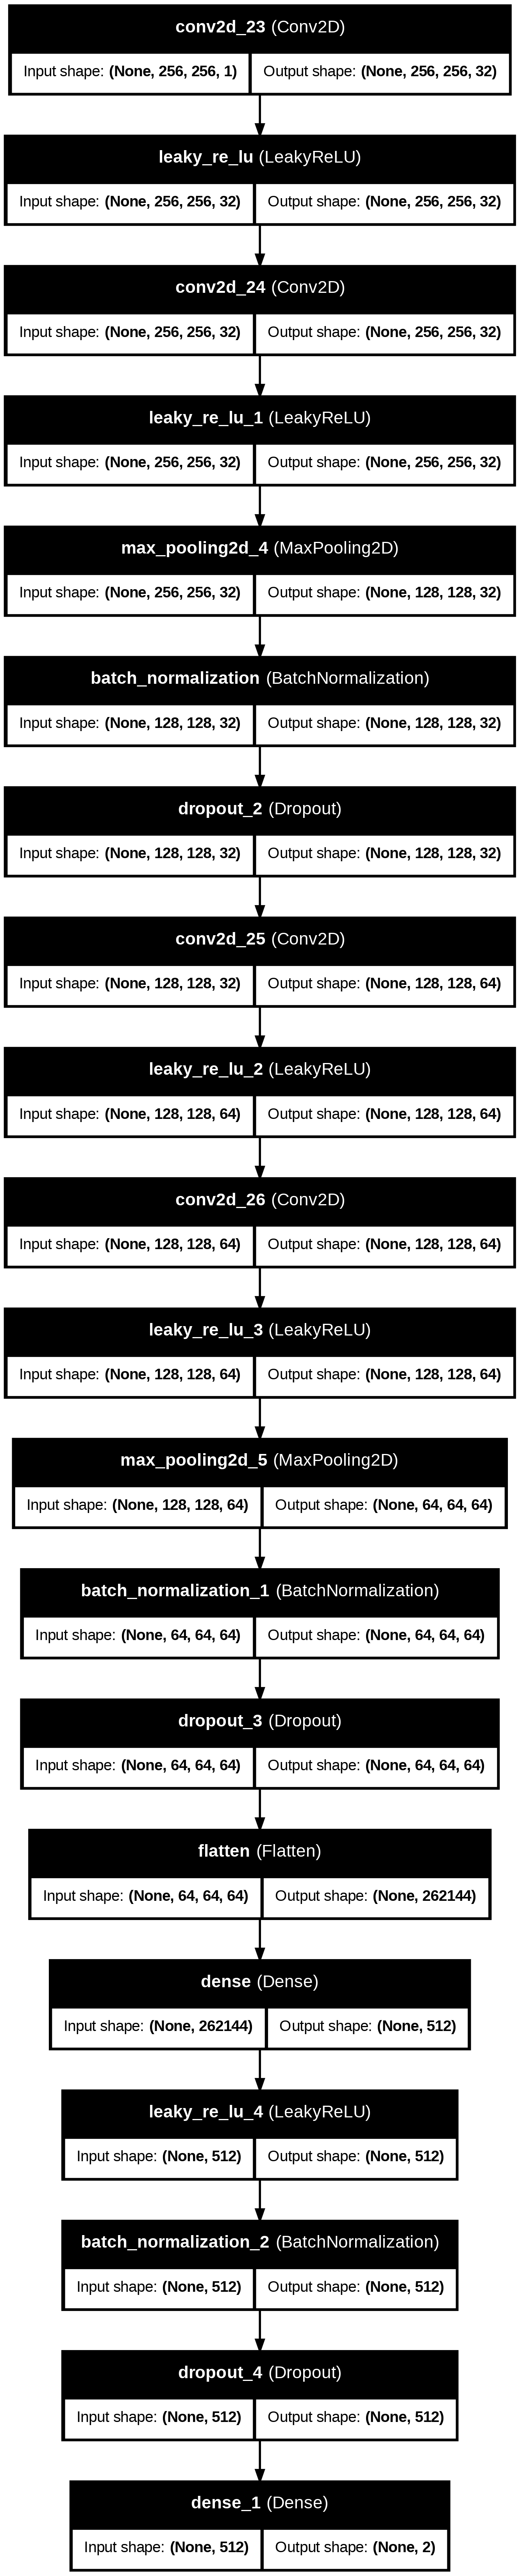

In [ ]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_c.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = model.fit(imgs_array,y_train_encoded,epochs=50,batch_size=64,validation_data=(valid_array,y_valid_encoded),callbacks=[callback])

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 907ms/step - accuracy: 0.5207 - loss: 1.7897 - val_accuracy: 0.5000 - val_loss: 0.7085
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy: 0.4921 - loss: 1.0218 - val_accuracy: 0.5000 - val_loss: 0.6991
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 0.4887 - loss: 0.7379 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.4988 - loss: 0.7120 - val_accuracy: 0.5000 - val_loss: 0.6992
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.5019 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.6984
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.5052 - loss: 0.6970 - val_accuracy: 0.5000 - val_loss: 0.7030
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.4873 - loss: 0.7022 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.4894 - loss: 0.6998 - val_accu

In [ ]:
model.save('classification.h5')

In [ ]:
model = load_model('classification.h5')

In [ ]:
import math
testing_data = model.evaluate(valid_array, y_valid_encoded)
accuracy = testing_data[1]
print("Testing Accuracy:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.2591 - loss: 0.5723
Testing Accuracy: 0.5


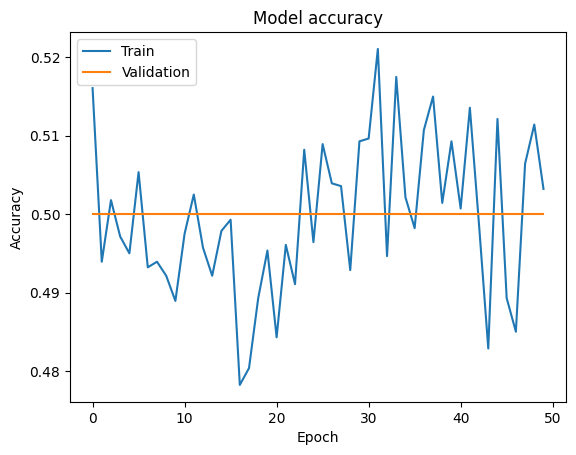

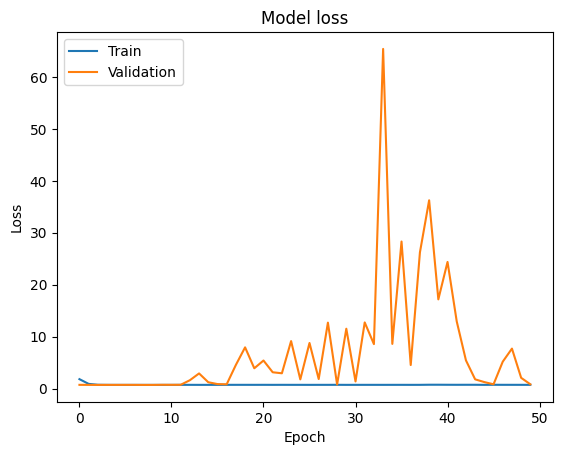

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
labels_replaced = [0 if label == "no" else 1 for label in valid_labels]

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Compute classification report
classification_report_str = classification_report(valid_labels, predicted_labels)
print("Classification Report:")
print(classification_report_str)


Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



In [ ]:
from sklearn.metrics import classification_report, roc_auc_score


# Get the validation predictions
valid_predictions = model.predict(valid_array)
# Assuming valid_labels is the true labels for validation data
valid_labels = labels_replaced  # Replace with your actual labels

# Convert probabilities to class labels (assuming binary classification)
predicted_labels = np.argmax(valid_predictions, axis=1)

# Print total images trained and validated
total_images_trained = len(imgs_array)
total_images_validated = len(valid_array)
print("Total Images Trained:", total_images_trained)
print("Total Images Validated:", total_images_validated)

# Compute number of correctly and wrongly predicted images
correctly_predicted = np.sum(predicted_labels == valid_labels)
wrongly_predicted = total_images_validated - correctly_predicted
print("Number of Images Correctly Predicted:", correctly_predicted)
print("Number of Images Wrongly Predicted:", wrongly_predicted)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Total Images Trained: 2800
Total Images Validated: 200
Number of Images Correctly Predicted: 100
Number of Images Wrongly Predicted: 100


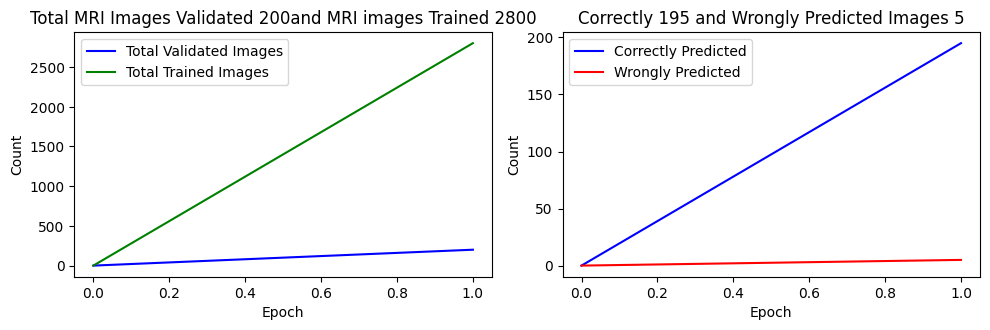

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have access to other evaluation metrics like total images, correctly predicted, wrongly predicted, etc.
total_images_validated = 200 # Example value
total_images_trained = 2800   # Example value
correctly_predicted = 195     # Example value
wrongly_predicted = 5      # Example value

# Plotting
plt.figure(figsize=(10, 6))

# Plot total images validated and trained
plt.subplot(2, 2, 1)
plt.plot([0, 1], [0, total_images_validated], label='Total Validated Images', color='blue')
plt.plot([0, 1], [0, total_images_trained], label='Total Trained Images', color='green')
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title(f'Total MRI Images Validated {total_images_validated}and MRI images Trained {total_images_trained}')
plt.legend()

# Plot number of images correctly and wrongly predicted
plt.subplot(2, 2, 2)
plt.plot([0, 1], [0, correctly_predicted], label='Correctly Predicted', color='blue')
plt.plot([0, 1], [0, wrongly_predicted], label='Wrongly Predicted', color='red')
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title(f'Correctly {correctly_predicted} and Wrongly Predicted Images {wrongly_predicted}')
plt.legend()


# Show plots
plt.tight_layout()
plt.show()


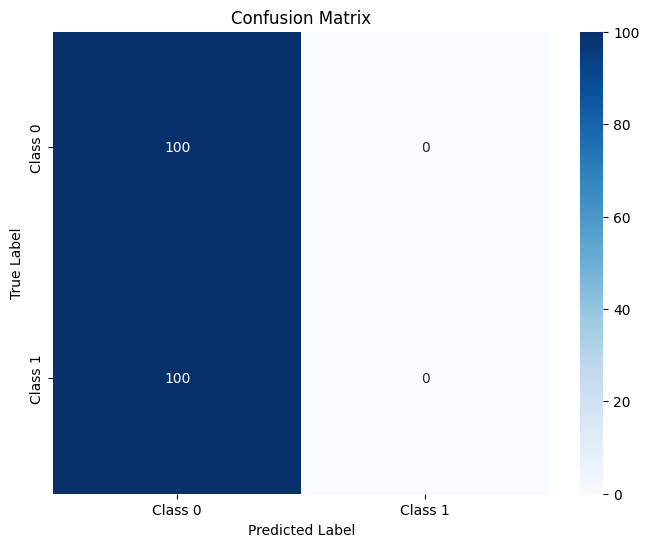

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming valid_labels_numeric are the true labels and predicted_labels are the predicted labels
# valid_labels_numeric should contain numerical labels (0 and 1)
# predicted_labels should contain the predicted numerical labels

# Compute confusion matrix
conf_matrix = confusion_matrix(valid_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
